In [8]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
%matplotlib inline

import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras
import tensorflow as tf
from keras.callbacks import *
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
# scalable hyperparameter optimization framework using hyperparameter search
import keras_tuner as kt

In [2]:
os.chdir(r"C:/Users/chaou/covid19-radiography-database/")

In [3]:
df_images = pd.read_csv('df_images.csv')
df_masques = pd.read_csv('df_masks.csv')

In [4]:
df_images.head()

,FILE NAME,FORMAT,SIZE,LABEL,CHANNELS,PATH,URL,SOURCE,MEAN_INTENSITY
0,COVID-1,PNG,299x299,COVID,1,C:/Users/chaou/covid19-radiography-database/CO...,https://sirm.org/category/senza-categoria/covi...,sirm.org,0.572145
1,COVID-10,PNG,299x299,COVID,1,C:/Users/chaou/covid19-radiography-database/CO...,https://sirm.org/category/senza-categoria/covi...,sirm.org,0.554335
2,COVID-100,PNG,299x299,COVID,1,C:/Users/chaou/covid19-radiography-database/CO...,https://sirm.org/category/senza-categoria/covi...,sirm.org,0.599524
3,COVID-1000,PNG,299x299,COVID,1,C:/Users/chaou/covid19-radiography-database/CO...,https://github.com/ieee8023/covid-chestxray-da...,github.com,0.638318
4,COVID-1001,PNG,299x299,COVID,1,C:/Users/chaou/covid19-radiography-database/CO...,https://github.com/ieee8023/covid-chestxray-da...,github.com,0.509376


In [14]:
# Fonction pour faciliter le preprocessing des images
def preproc_img(df_images, df_masks, n_img, resolution=[299, 299, 3], with_masks=False):

    # Gestion des erreurs
    if (resolution[2] != 1 and resolution[2] != 3):
        print("Le nombre de canaux doit être de 1 (en nuances de gris) ou de 3 (en couleur)")
        return

    if (resolution[0] != resolution[1]):
        print("La largeur de l'image doit être la même que sa hauteur.")
        return

    if (n_img > df_images.groupby('LABEL').size().min()):
        print("Il n'y a pas assez d'images dans au moins une classe.")
        return
    
    # Initialiser une liste pour stocker les images prétraitées
    images = []

    # Sélectionner le nombre d'image à utiliser par classe
    df_images_selected = df_images.groupby('LABEL').sample(n = n_img, replace = False)
    df_masks_selected = df_masks[df_masks['FILE NAME'].isin(df_images_selected['FILE NAME'])] if with_masks else None

    for i in range(len(df_images_selected)):
        # Récupérer les chemins des images et des masques
        img_path = df_images_selected['PATH'].iloc[i]
        mask_path = df_masks_selected['PATH'].iloc[i] if with_masks else None

        # Chargement de l'image en nuances de gris et en 8 bits
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

        if resolution[2] == 3:
            # Chargement de l'image en couleur
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        img_resized = cv2.resize(img, (resolution[0], resolution[1]))

        # Normalisation des valeurs des pixels
        img_normalized = img_resized #/ 255.0

        if with_masks:
            # Application des masques par défaut
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
            mask_resized = cv2.resize(mask, (resolution[0], resolution[1]))
            img_masked = cv2.bitwise_and(img_normalized, img_normalized, mask = mask_resized)
            # Ajout de l'image à la liste
            images.append(img_masked)
        else:
            images.append(img_normalized)

    # Reshaper pour ajouter la dimension du canal
    data = np.array(images).reshape(-1, resolution[0], resolution[1], resolution[2])
    target = df_images_selected['LABEL']

    return data, target


### 3. Models Benchmark : EfficientNet


In [6]:
# List of models to benchmark

from tensorflow.keras.applications import *

# models dict
models_dict = {EfficientNetB0: 224,
               EfficientNetB1: 240,
               EfficientNetB2: 260,
               EfficientNetB3: 300,
               EfficientNetB4: 380,
               EfficientNetB5: 456,
               EfficientNetB6: 528,
               EfficientNetB7: 600}

# Store accuracy history of each model in a list
train_accuracies = []
valid_accuracies = []

for keras_model in models_dict.keys():

    # 1. Import the models --------------------------------------------------------------------------------------------------
    # Show current model and its resolution 
    print("The selected model is:", str(keras_model))
    resolution = (models_dict[keras_model], models_dict[keras_model], 3)
    print("The selected model resolution is:", resolution, '\n')
    
 
    # Instanciate the KERAS model a "base model" object
    base_model = keras_model(weights='imagenet', include_top=False, input_shape=resolution)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 2. Data preprocessing : Train, Test sets -----------------------------------------------------------------------------
    data, target = preproc_img(df_images=df_images, df_masks=df_masques, n_img=900, resolution=resolution, with_masks=False)

    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    print("X_train shape:", X_train.shape)
    print("X_test  shape:", X_test.shape)

    print("Max value X_train:", X_train.max())
    print("Max value X_test :", X_train.max())

    label_encoder = LabelEncoder()
    # Encoder les labels textuels en entiers
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded  = label_encoder.transform(y_test)

    # Appliquer l'encodage one-hot
    y_train = to_categorical(y_train_encoded)
    y_test = to_categorical(y_test_encoded)

    # Vérifier la transformation
    print("Labels de l'ensemble d'entrainement après encodage one-hot :", y_train.shape)
    print("Labels de l'ensemble de test après encodage one-hot        :", y_test.shape)

    # 3. Build, compile and train the models ------------------------------------------------------------------------------
    # Building the globla model : base model + some custom layers
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

    # 3. Show the performance results -------------------------------------------------------------------------------------
    # Save histories
    train_accuracies.append(hist.history['accuracy'])
    valid_accuracies.append(hist.history['val_accuracy'])
   

The selected model is: <function EfficientNetB0 at 0x000002150E8E8E00>
The selected model resolution is: (224, 224, 3) 

X_train shape: (2880, 224, 224, 3)
X_test  shape: (720, 224, 224, 3)
Max value X_train: 255
Max value X_test : 255
Labels de l'ensemble d'entrainement après encodage one-hot : (2880, 4)
Labels de l'ensemble de test après encodage one-hot        : (720, 4)
Epoch 1/20
37/72 ━━━━━━━━━━━━━━━━━━━━ 18s 519ms/step - accuracy: 0.5853 - loss: 1.4164


KeyboardInterrupt



In [ ]:
# SHow the results

df_train_acc = pd.DataFrame(np.array(train_accuracies).T)
df_valid_acc = pd.DataFrame(np.array(valid_accuracies).T)

df_train_acc.to_csv('df_train_acc_900images.csv')
df_valid_acc.to_csv('df_valid_acc_900images.csv')

x = np.arange(21)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i in np.arange(len(df_train_acc.columns)):

    # Graph 1: Training accuracy
    axes[0].plot(df_train_acc.index+1, df_train_acc[i], marker='+', label='EfficientNet' + str(i))
    axes[0].set_title("Train accuracy")
    axes[0].legend(loc='upper right')

    # Graph 2: Validation accuracy
    axes[1].plot(df_train_acc.index+1, df_valid_acc[i], marker='+', label='EfficientNet' + str(i))
    axes[1].set_title("Train accuracy")
    axes[1].legend(loc='upper right')


fig.suptitle('Models performance')
plt.show();

### 3.1 Saved Benchmark data

In [12]:
df = pd.read_csv('EfficientNet_models_benchmark_vf.csv')
df

,Unnamed: 0,model,accuracy,loss,val_accuracy,val_loss,epochs
0,0,EfficientNetB0,0.6933,0.9320,0.8976,0.3123,1
1,1,EfficientNetB0,0.9274,0.1983,0.8941,0.2931,2
2,2,EfficientNetB0,0.9553,0.1177,0.8802,0.3298,3
3,3,EfficientNetB0,0.9846,0.0591,0.8924,0.2893,4
4,4,EfficientNetB0,0.9885,0.0421,0.8976,0.3243,5
...,...,...,...,...,...,...,...
135,135,EfficientNetB6,0.9841,0.0461,0.8889,0.6101,16
136,136,EfficientNetB6,0.9915,0.0274,0.8924,0.6559,17
137,137,EfficientNetB6,0.9968,0.0121,0.8715,0.7562,18
138,138,EfficientNetB6,0.9966,0.0122,0.8993,0.6421,19


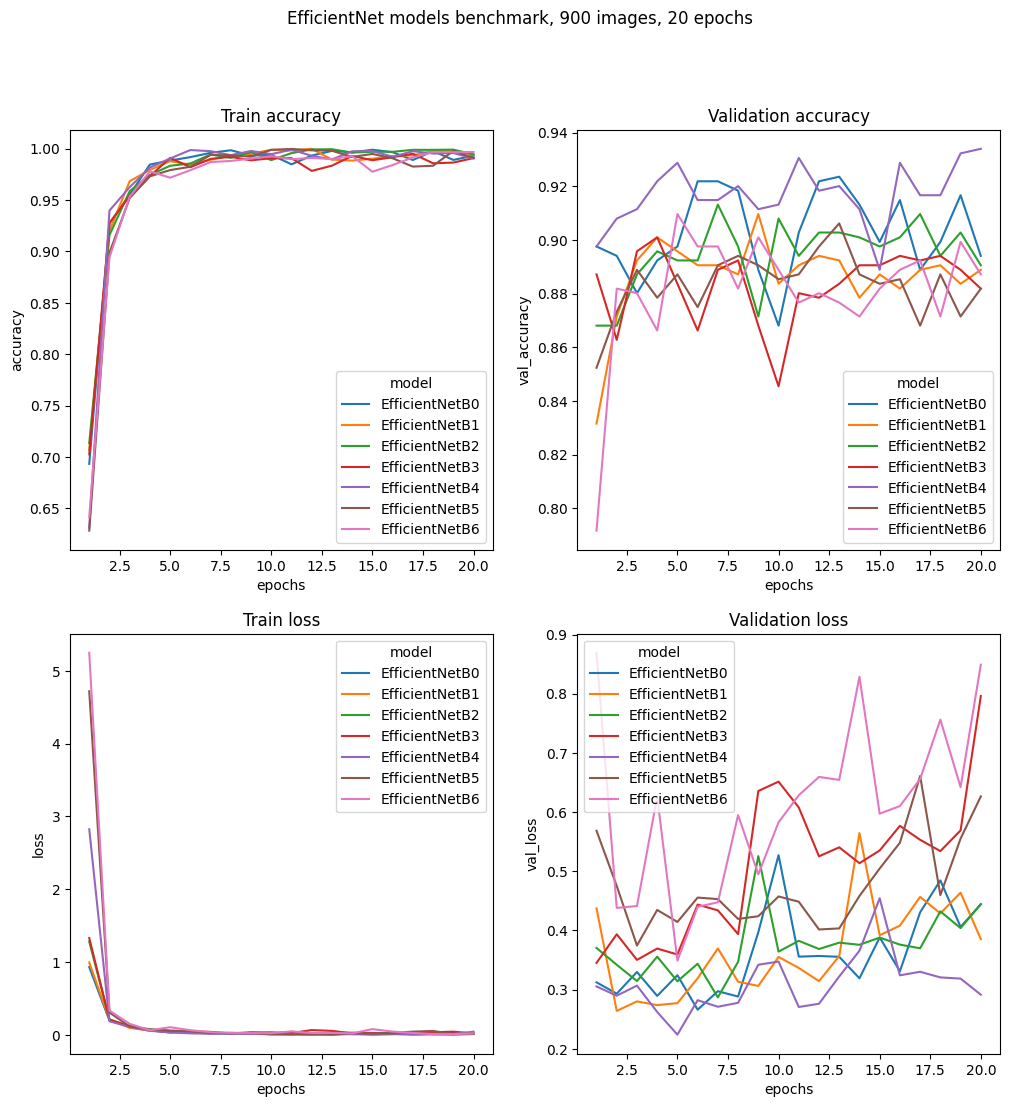

In [13]:
#sns.lineplot(x=np.array(df.index[0:20]), y=df.accuracy[0:20].values, markers=True, data=df[0:20]);

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('EfficientNet models benchmark, 900 images, 20 epochs')

sns.lineplot(ax=axes[0, 0], data=df, x='epochs', y='accuracy', hue='model', markers=True);
axes[0, 0].set_title('Train accuracy')

sns.lineplot(ax=axes[0, 1], data=df, x='epochs', y='val_accuracy', hue='model', markers=True);
axes[0, 1].set_title('Validation accuracy')

sns.lineplot(ax=axes[1, 0], data=df, x='epochs', y='loss', hue='model', markers=True);
axes[1, 0].set_title('Train loss')

sns.lineplot(ax=axes[1, 1], data=df, x='epochs', y='val_loss', hue='model', markers=True);
axes[1, 1].set_title('Validation loss')

plt.show();

### 3.2 Keras Tuner & unfreeze EfficientNetB4


In [15]:
# Data preprocessing
# Specify the models Input data resolution 
model_resolution = [380, 380, 3]

data, target = preproc_img(df_images=df_images, df_masks=df_masques, n_img=900, resolution=model_resolution, with_masks=False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

print("Max value X_train:", X_train.max())
print("Max value X_test :", X_train.max())

label_encoder = LabelEncoder()
# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded  = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

# Vérifier la transformation
print("Labels de l'ensemble d'entrainement après encodage one-hot :", y_train.shape)
print("Labels de l'ensemble de test après encodage one-hot        :", y_test.shape)


X_train shape: (2880, 380, 380, 3)
X_test  shape: (720, 380, 380, 3)
Max value X_train: 255
Max value X_test : 255
Labels de l'ensemble d'entrainement après encodage one-hot : (2880, 4)
Labels de l'ensemble de test après encodage one-hot        : (720, 4)


In [7]:
# Import EffcientNet model
from keras.applications import EfficientNetB4


### 3.2.1 Keras Tuner

In [15]:
# Keras-Tuner model builder function
def model_builder(hp):

    # Save random states
    np.random.seed(42)

    # Import EffcientNetB4 model
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))

    # Unfreeze the last 15 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Define hyperparameters
    
    # Tune number of units
    hp_dense_1 = hp.Int('dense1_units', min_value=32, max_value=1024, step=32) 
    hp_dense_2 = hp.Int('dense2_units', min_value=32, max_value=1024, step=32)
    
    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    x = Flatten()(base_model.output)
    x = Dense(hp_dense_1, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(hp_dense_2, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    predictions = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Model compilation 
    model.compile(optimizer=tf.keras.optimizers.Adam(hp_learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

model_builder(kt.HyperParameters())

<Functional name=functional_2, built=True>

In [19]:
# Tuner class to run the search 

tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory=r"C:/Users/chaou/covid19-radiography-database/",
    project_name="DST_project_radio_covid")

tuner.search_space_summary()


Search space summary
Default search space size: 3
dense1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
dense2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1, mode='min')


In [21]:
# Execute the search 
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

Trial 10 Complete [00h 34m 35s]
val_accuracy: 0.8958333134651184

Best val_accuracy So Far: 0.9201388955116272
Total elapsed time: 06h 34m 22s


In [22]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()


C:\Users\chaou\anaconda3\envs\tf_CPU\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 380, 380,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 380, 380,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 380, 380,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 381, 381,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 190, 190,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 190, 190,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 190, 190,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 190, 190,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 190, 190,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 190, 190,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 190, 190,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 190, 190,  │      1,152 │ block1a_se_excit

 Total params: 207,858,723 (792.92 MB)

 Trainable params: 190,184,900 (725.50 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [26]:
# Best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0].values
best_hps

{'dense1_units': 736, 'dense2_units': 352, 'learning_rate': 0.0001}

### 3.2.2 Unfreeze Layers EfficientNetB4

In [27]:
# Save random states
np.random.seed(42)

from keras.applications import EfficientNetB4

# Import EffcientNetB4 model
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = BatchNormalization()(x)

x = Dense(1024, activation='relu', name='dense_1')(x)  
x = Dropout(0.2, name="top_dropout1")(x)

x = Dense(512, activation='relu', name='dense_2')(x)       
x = Dropout(0.2, name="top_dropout2")(x)

outputs = Dense(4, activation="softmax", name="pred")(x)

B4_model = keras.Model(inputs=base_model.input, outputs=outputs, name="EfficientNet")

B4_model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
# model training
hist = B4_model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.6267 - loss: 0.8891 - val_accuracy: 0.7969 - val_loss: 0.8102
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.8245 - loss: 0.4530 - val_accuracy: 0.8455 - val_loss: 0.5871
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.8666 - loss: 0.3480 - val_accuracy: 0.8559 - val_loss: 0.4537
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.8905 - loss: 0.3001 - val_accuracy: 0.8698 - val_loss: 0.3662
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.9054 - loss: 0.2687 - val_accuracy: 0.8750 - val_loss: 0.3313
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.9071 - loss: 0.2446 - val_accuracy: 0.8785 - val_loss: 0.3195
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.9258 - loss: 0.2137 - val_accuracy: 0.8785 - val_loss: 0.2887
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.9426 - loss: 0.1678 - val_accuracy: 0.8941 - v

In [29]:
hist_dict = {'Accuracy' : hist.history['accuracy'],
             'Loss' : hist.history['loss'],
             'Val_accuracy' : hist.history['val_accuracy'],
             'Val_loss' : hist.history['val_loss']}

df_EfficientNetB4_hist = pd.DataFrame(hist_dict)
df_EfficientNetB4_hist['epochs'] = np.arange(1, 21)
df_EfficientNetB4_hist.head()


,Accuracy,Loss,Val_accuracy,Val_loss,epochs
0,0.715712,0.708396,0.796875,0.810245,1
1,0.833767,0.431938,0.845486,0.587121,2
2,0.866753,0.351378,0.855903,0.453732,3
3,0.891493,0.295376,0.869792,0.366235,4
4,0.902778,0.267756,0.875000,0.331283,5


In [19]:
df_EfficientNetB4_hist.to_csv('EfficientNetB4_base_model_hist.csv', index=False)

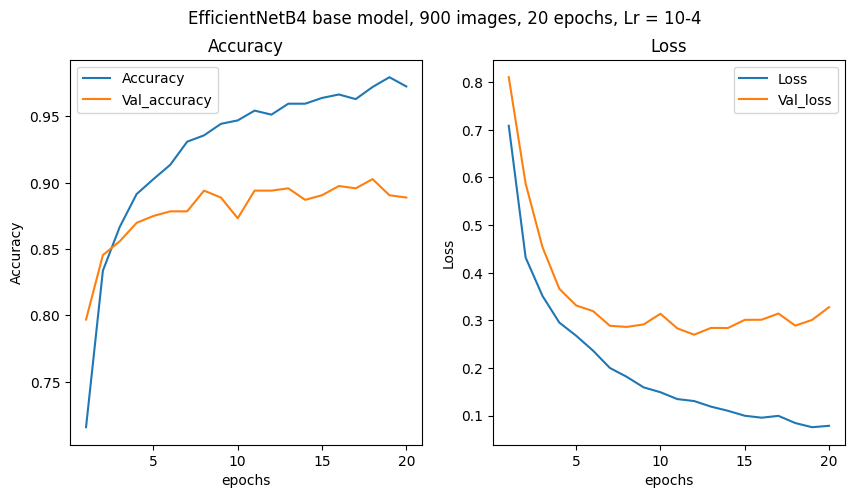

In [30]:
#sns.lineplot(x=np.array(df.index[0:20]), y=df.accuracy[0:20].values, markers=True, data=df[0:20]);

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('EfficientNetB4 base model, 900 images, 20 epochs, Lr = 10-4')

sns.lineplot(ax=axes[0], data=df_EfficientNetB4_hist, x='epochs', y='Accuracy', label='Accuracy', markers=True);
sns.lineplot(ax=axes[0], data=df_EfficientNetB4_hist, x='epochs', y='Val_accuracy', label='Val_accuracy', markers=True);
axes[0].set_title('Accuracy')


axes[1].set_title('Loss')
sns.lineplot(ax=axes[1], data=df_EfficientNetB4_hist, x='epochs', y='Loss', label='Loss', markers=True);
sns.lineplot(ax=axes[1], data=df_EfficientNetB4_hist, x='epochs', y='Val_loss', label='Val_loss', markers=True);

plt.legend()
plt.show();

In [31]:
# Confusion matrix and Classification report
EfficientNetB4_preds = B4_model.predict(X_test)


23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step


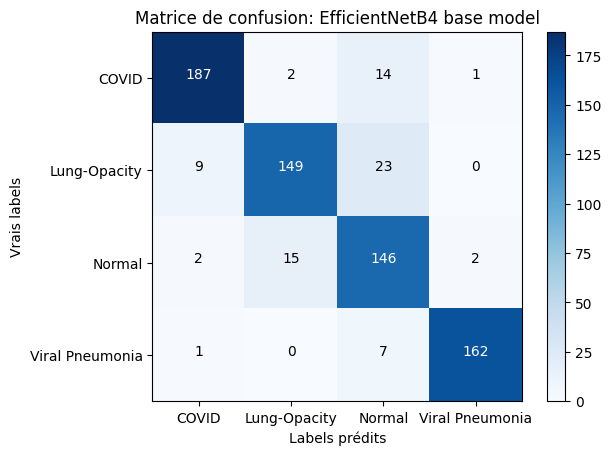

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification
import itertools # Pour créer des itérateurs

test_pred_EfficientNetB4_class = EfficientNetB4_preds.argmax(axis=1)
y_test_class = y_test.argmax(axis=1)

# Matrice de confusion en couleurs  
cnf_matrix = confusion_matrix(y_test_class, test_pred_EfficientNetB4_class)

class_name = ['COVID', 'Lung-Opacity', 'Normal', 'Viral Pneumonia']

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion: EfficientNetB4 base model")
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name)
plt.yticks(tick_marks, class_name)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()


In [33]:
# Classiifcation report
print(classification_report(y_test_class, test_pred_EfficientNetB4_class, target_names=class_name))

                 precision    recall  f1-score   support

          COVID       0.94      0.92      0.93       204
   Lung-Opacity       0.90      0.82      0.86       181
         Normal       0.77      0.88      0.82       165
Viral Pneumonia       0.98      0.95      0.97       170

       accuracy                           0.89       720
      macro avg       0.90      0.89      0.89       720
   weighted avg       0.90      0.89      0.90       720



#### Grad CAM for EfficientNet


In [120]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt


The chosen image's class is: 17568    Normal
Name: LABEL, dtype: object


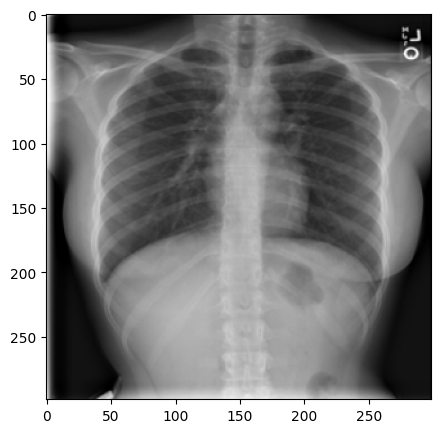

In [232]:
# test image
img_path = np.random.choice(df_images['PATH'])
print("The chosen image's class is:", df_images[df_images["PATH"]==img_path]['LABEL'])
image = imread(img_path)

plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.show();

In [233]:
labels_to_show = ['COVID', 'Lung-Opacity', 'Normal', 'Viral Pneumonia']
labels_to_show = np.array(labels_to_show)
labels_to_show

array(['COVID', 'Lung-Opacity', 'Normal', 'Viral Pneumonia'], dtype='<U15')

In [234]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

resolution = [380, 380, 3]


# Chargement de l'image en nuances de gris et en 8 bits
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)

if resolution[2] == 3:
    # Chargement de l'image en couleur
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

img_resized = cv2.resize(img, (resolution[0], resolution[1]))

# Reshaper pour ajouter la dimension du canal
data = np.array(img_resized).reshape(-1, resolution[0], resolution[1], resolution[2])

preprocessed_input = data
preprocessed_input.shape

(1, 380, 380, 3)

In [235]:
predic_img_class = frozon_model.predict(preprocessed_input)
predic_img_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


array([[4.1649653e-08, 9.2140148e-08, 9.9999988e-01, 2.3357360e-16]],
      dtype=float32)

In [236]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras.applications.efficientnet import preprocess_input, decode_predictions

In [237]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [238]:
img_size = (380, 380)
preprocess_input = keras.applications.efficientnet.preprocess_input
decode_predictions = keras.applications.efficientnet.decode_predictions
last_conv_layer_name = 'top_conv'


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: [('n07714571', 'head_cabbage', 5.2853293)]


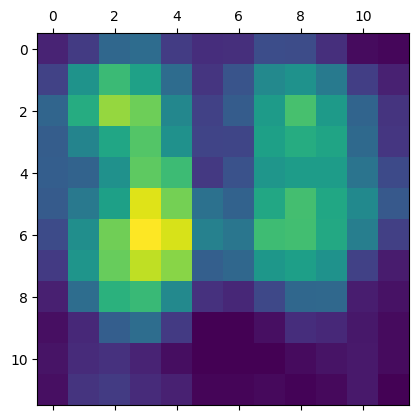

In [239]:
# Test
model_builder = EfficientNetB4

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

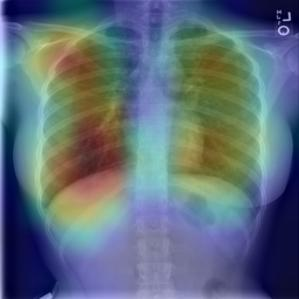

In [240]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)